<a href="https://colab.research.google.com/github/laurelkeys/machine-learning/blob/master/assignment-4/Gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies and setup Drive

In [0]:
!pip install PyDrive > /dev/null 2>&1

In [0]:
import os
import zipfile

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from random import randrange

from google.colab import auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)

## Download and unzip data

In [0]:
# Enable link sharing for data.zip in your Drive and copy the link:
# https://drive.google.com/open?id=YOUR_FILE_ID

YOUR_FILE_ID = '1fd1iyyeOpwAleUGv7QH23ocucxCzK4xt'

In [0]:
download = gdrive.CreateFile({'id': YOUR_FILE_ID})

save_folder = "data" # /content/data
os.makedirs(save_folder, exist_ok=True)
download.GetContentFile(os.path.join(save_folder, "data.zip"))

In [6]:
!ls -lh data

total 92M
-rw-r--r-- 1 root root 92M Dec  5 00:52 data.zip


In [0]:
zip_ref = zipfile.ZipFile("/content/data/data.zip", 'r')
zip_ref.extractall("/content/data/")
zip_ref.close()

In [0]:
PATH_TO_DATASET = os.path.join("data", "content", "data") # data/data.zip -> data/content/data/*

In [9]:
!du -sh data/data.zip
!du -sh data/content

92M	data/data.zip
356M	data/content


In [10]:
print("================")
for game_folder in os.listdir("data/content/data"):
    if game_folder != "results":
        print(game_folder + '/')
        trajectory_folders = sorted([d for d in os.listdir(f"data/content/data/{game_folder}")])
        print("├──", trajectory_folders[0] + '/')  # 0
        print("├── ...")
        print("├──", trajectory_folders[-2] + '/') # N_OF_TRAJECTORIES
        print("└──", trajectory_folders[-1] + '/') # 'images'
        
        images_folders = sorted([d for d in os.listdir(f"data/content/data/{game_folder}/images")])
        # print("    ├──", images_folders[0] + '/')
        # print("    ├── ...")
        # print("    └──", images_folders[-1] + '/')
        
        last_images_folder = sorted([d for d in os.listdir(f"data/content/data/{game_folder}/images/{images_folders[-1]}")])
        # print("        ├──", last_images_folder[0] + '/')
        # print("        ├── ...")
        # print("        └──", last_images_folder[-1] + '/')

        print(f"Trajectories: {int(images_folders[-1]) - int(images_folders[0]) + 1}")
        print(f"Steps per trajectory: {int(last_images_folder[-1][:-4]) - int(last_images_folder[0][:-4]) + 1}")
        print("================")

BreakoutNoFrameskip-v4_PPO2_1000steps/
├── 00/
├── ...
├── 44/
└── images/
Trajectories: 45
Steps per trajectory: 1000
PongNoFrameskip-v4_PPO2_1000steps/
├── 00/
├── ...
├── 44/
└── images/
Trajectories: 45
Steps per trajectory: 1000


## Setup the dataset

In [0]:
# NOTE set these values according to the downloaded dataset
N_OF_TRAJECTORIES = 45
N_OF_STEPS = 1000

FILE_NAME = "trajectory.npz"

In [0]:
# actions go from 0 to 17
all_actions = np.empty((N_OF_TRAJECTORIES, N_OF_STEPS), dtype='int8')

# 'observations' stores the path to the PNG image of the state
all_obs_paths = np.empty((N_OF_TRAJECTORIES, N_OF_STEPS), dtype='<U60')
all_obs = np.empty((N_OF_TRAJECTORIES, N_OF_STEPS, 84, 84, 4), dtype='uint8')

In [13]:
for game_folder in os.listdir("data/content/data"):
    if game_folder != "results":
        print(game_folder + '/', end=' ')
        for data_folder in os.listdir(f"data/content/data/{game_folder}"):
            if data_folder != 'images':
                # 'actions', 'observations', 'rewards', 'episode_starts'
                data = np.load(f"data/content/data/{game_folder}/{data_folder}/{FILE_NAME}")
                
                trajectory = int(data_folder)
                all_actions[trajectory] = data['actions']
                all_obs_paths[trajectory] = data['observations']
        print("done.")

for trajectory in range(N_OF_TRAJECTORIES):
    for step in range(N_OF_STEPS):
        obs_path = all_obs_paths[trajectory, step]
        all_obs[trajectory, step] = cv2.imread(f"data/content/{obs_path}", 
                                               cv2.IMREAD_UNCHANGED) # keep the 4 channels
print("done.")

BreakoutNoFrameskip-v4_PPO2_1000steps/ done.
PongNoFrameskip-v4_PPO2_1000steps/ done.
done.


In [0]:
# dataset = zip(all_obs, all_actions) # each value is a tuple with shapes ((N_OF_STEPS, 84, 84, 4), (N_OF_STEPS,))
dataset = (all_obs, all_actions)

## Convert images to 3 channels

In [0]:
def plot_channels(image, figsize=None):
    chs = image.shape[-1] # number of channels
    fig = plt.figure(figsize=(3 * chs, 3 * chs) if figsize is None else figsize)
    for i in range(chs):
        img = np.stack((obs[:, :, i],) * 4, axis=-1)
        fig.add_subplot(1, chs + 1, i + 1)
        plt.axis('off'); plt.title(f"obs[:, :, {i}]"); plt.imshow(img)
    fig.add_subplot(1, chs + 1, chs + 1)
    plt.axis('off'); plt.title("obs[:, :, :]"); plt.imshow(obs)
    plt.show()

trajectory: 40 (of 45)
step: 665 (of 1000)



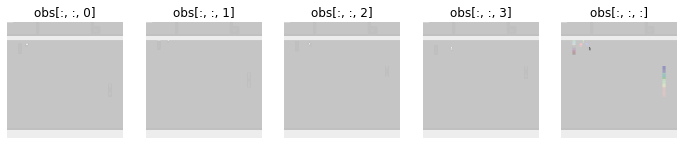

In [16]:
t, s = randrange(N_OF_TRAJECTORIES), randrange(N_OF_STEPS)
print(f"trajectory: {t} (of {N_OF_TRAJECTORIES})")
print(f"step: {s} (of {N_OF_STEPS})\n")
obs = all_obs[t, s] # (84, 84, 4)
plot_channels(obs)

In [0]:
def mix_channels(obs_image):
    assert obs_image.shape[-1] == 4, "expected an image with 4 channels"
    return np.stack([
        obs_image[:, :, 0:2].mean(axis=-1), 
        obs_image[:, :, 1:3].mean(axis=-1), 
        obs_image[:, :, 2:4].mean(axis=-1), 
    ], axis=-1) # (84, 84, 4) -> (84, 84, 3)

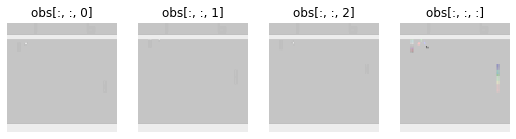

In [18]:
plot_channels(mix_channels(obs))

## Define the network architecture

In [19]:
try:
    # Colab only
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:
from tensorflow.keras.layers import InputLayer, Flatten, Dense, Conv2D, MaxPooling2D

In [0]:
N_OF_ACTIONS = 18
MODEL_INP_SHAPE = (84, 84, 4)

In [0]:
# obs.: padding='valid' by default (i.e. no padding)
model = keras.Sequential([
    InputLayer(input_shape=MODEL_INP_SHAPE),
    Conv2D(filters=32, kernel_size=3, strides=(2, 2), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=64, kernel_size=3, strides=(2, 2), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(N_OF_ACTIONS, activation='softmax'),
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 42, 42, 32)        1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               409856    
_________________________________________________________________
dense_1 (Dense)              (None, 18)                4

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
MAX_EPOCHS = 64
BATCH_SIZE = 512
TF_VERBOSE = 1 # 0 = silent, 1 = progress bar, 2 = one line per epoch

In [0]:
X, Y = dataset

In [27]:
print(X.shape, Y.shape)
X = X.reshape(-1, 84, 84, 4)
Y = Y.reshape(-1)
print(X.shape, Y.shape)

(45, 1000, 84, 84, 4) (45, 1000)
(45000, 84, 84, 4) (45000,)


In [28]:
Y_onehot = np.zeros((Y.size, N_OF_ACTIONS))
Y_onehot[np.arange(Y.size), Y] = 1
print(Y_onehot.shape)

(45000, 18)


In [29]:
model.fit(x=X, y=Y_onehot,
          validation_split=0.2,
          epochs=MAX_EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=TF_VERBOSE)

Train on 36000 samples, validate on 9000 samples
Epoch 1/64
36000/36000 [==============================] - 7s 187us/sample - loss: 11.5933 - accuracy: 0.2002 - val_loss: 1.7482 - val_accuracy: 0.2316
Epoch 2/64
36000/36000 [==============================] - 1s 41us/sample - loss: 1.6865 - accuracy: 0.2875 - val_loss: 1.6444 - val_accuracy: 0.3022
Epoch 3/64
36000/36000 [==============================] - 1s 41us/sample - loss: 1.5970 - accuracy: 0.3386 - val_loss: 1.5768 - val_accuracy: 0.3464
Epoch 4/64
36000/36000 [==============================] - 1s 41us/sample - loss: 1.5470 - accuracy: 0.3614 - val_loss: 1.5832 - val_accuracy: 0.3420
Epoch 5/64
36000/36000 [==============================] - 1s 41us/sample - loss: 1.5097 - accuracy: 0.3777 - val_loss: 1.5332 - val_accuracy: 0.3649
Epoch 6/64
36000/36000 [==============================] - 1s 41us/sample - loss: 1.4830 - accuracy: 0.3949 - val_loss: 1.5245 - val_accuracy: 0.3649
Epoch 7/64
36000/36000 [==============================]